In [1]:
import pandas as pd
import numpy as np
import calendar
import math
import re
import string

In [2]:
import os
os.chdir('/home/studio-lab-user/sagemaker-studiolab-notebooks/TCube')
import segmentation
import utils
import data2graph
from finetuned import T5FineTuner, BARTFineTuner, generate, generate_beam, graph2text_nobeam, graph2text_nobeam_ngram_es, graph2text_nobeam_topk, graph2text_nobeam_topp

/home/studio-lab-user/.conda/envs/py36/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import textstat
import language_tool_python
from lexical_diversity import lex_div as ld

### Loading Fine-Tuned PLMs

In [4]:
import torch
cuda0 = torch.device("cuda:0")
#cuda1 = torch.device("cuda:1")
#cuda3 = torch.device("cuda:3")

t5 = T5FineTuner.load_from_checkpoint("Finetune PLMs/checkpoints/val_avg_bleu=0.0000-step_count=0.ckpt")
#bart = BARTFineTuner.load_from_checkpoint("BARTModels/BARTBoth.ckpt")

t5.to(cuda0)
#bart.to(cuda0)

T5FineTuner(
  (model): T5ForConditionalGeneration(
    (shared): Embedding(32103, 512)
    (encoder): T5Stack(
      (embed_tokens): Embedding(32103, 512)
      (block): ModuleList(
        (0): T5Block(
          (layer): ModuleList(
            (0): T5LayerSelfAttention(
              (SelfAttention): T5Attention(
                (q): Linear(in_features=512, out_features=512, bias=False)
                (k): Linear(in_features=512, out_features=512, bias=False)
                (v): Linear(in_features=512, out_features=512, bias=False)
                (o): Linear(in_features=512, out_features=512, bias=False)
                (relative_attention_bias): Embedding(32, 8)
              )
              (layer_norm): T5LayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (1): T5LayerFF(
              (DenseReluDense): T5DenseReluDense(
                (wi): Linear(in_features=512, out_features=2048, bias=False)
                (wo): Linear(in_feature

### Global Temperature

In [18]:
all_dfs

[     year  TenYearAverageTemperature        Country
 0    1834                   8.671000  United States
 1    1835                   8.528275  United States
 2    1836                   8.426767  United States
 3    1837                   8.315008  United States
 4    1838                   8.185025  United States
 ..    ...                        ...            ...
 174  2008                   9.689717  United States
 175  2009                   9.646725  United States
 176  2010                   9.632308  United States
 177  2011                   9.608742  United States
 178  2012                   9.653233  United States
 
 [179 rows x 3 columns],      year  TenYearAverageTemperature         Country
 0    1834                   8.613408  United Kingdom
 1    1835                   8.556683  United Kingdom
 2    1836                   8.429933  United Kingdom
 3    1837                   8.367342  United Kingdom
 4    1838                   8.173550  United Kingdom
 ..    ...    

In [24]:
#Import Land Temp Dataset
ds_gtemp = pd.read_csv("Data/GlobalTemperature/GlobalLandTemperaturesByCountry.csv")

countries = ['United States', 'United Kingdom', 'France', 'Spain', 'Italy', 'Germany', 'Russia']
all_dfs = []
for c in countries:
    country_df = ds_gtemp.loc[ds_gtemp['Country']==c]
    country_df['dt']=pd.to_datetime(country_df['dt'])
    rolling_df = (country_df[(country_df['dt'].dt.month<=12) 
                            & (country_df['dt'].dt.year>=1825) 
                            & (country_df['dt'].dt.year<=2012)]
    .groupby(country_df['dt'].dt.year)[['AverageTemperature']].mean()
    .rolling(10).mean()
    .dropna()
    .reset_index()
    .rename(columns={'dt':'year', 'AverageTemperature': 'TenYearAverageTemperature'}))
    rolling_df['Country'] = c
    all_dfs.append(rolling_df)

ds_gtemp = pd.concat(all_dfs, axis=0)
ds_gtemp = ds_gtemp.dropna()
ds_gtemp['month'] = 'July'
ds_gtemp['day'] = 1
ds_gtemp['dt'] = pd.to_datetime(ds_gtemp[['year', 'month', 'day']].astype(str).agg('-'.join, axis=1),format='%Y-%B-%d')
ds_gtemp.set_index(['dt'],inplace=True)

/home/studio-lab-user/.conda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/studio-lab-user/.conda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/studio-lab-user/.conda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

In [43]:
#RE Scores
template_re_scores = []
t5_re_scores = []
t5_re_scores_topk = []
t5_re_scores_topp = []
#bart_re_scores = []
#bart_re_scores_topk = []
#bart_re_scores_topp = []

#Diveristy Scores
template_tte_scores = []
t5_tte_scores = []
t5_tte_scores_topk = []
t5_tte_scores_topp = []
#bart_tte_scores = []
#bart_tte_scores_topk = []
#bart_tte_scores_topp = []

#Grammar Scores
t5_g_scores = []
t5_g_scores_topk = []
t5_g_scores_topp = []
#bart_g_scores = []
#bart_g_scores_topk = []
#bart_g_scores_topp = []

#Grammar Mistakes
t5_g_mistake = []
t5_g_mistake_topk = []
t5_g_mistake_topp = []
#bart_g_mistake = []
#bart_g_mistake_topk = []
#bart_g_mistake_topp = []

#countries = ['United States', 'India', 'Brazil', 'Russia', 'United Kingdom', 'France', 'Spain', 'Italy' , 'Turkey', 'Germany']

all_t5_narrative = []
all_t5_narrative_topk = []
all_t5_narrative_topp = []
all_country = []
all_country_gtemp_raw = []

for c in countries:
    
    print("Processing Country: ", c)
    
    country = ds_gtemp[ds_gtemp['Country']==c][['TenYearAverageTemperature','year', 'month']].reset_index().drop(columns=['dt'])
    country_gtemp_raw = country['TenYearAverageTemperature'].tolist()
    
    all_country.append(country)
    all_country_gtemp_raw.append(country_gtemp_raw)
    
    #Log-normalize data
    trans = np.ma.log(country_gtemp_raw)
    country_gtemp = trans.filled(0)
    
    print("\n Data Loaded")
    
    #Detecting Waves
    embeds, cluster_labels = segmentation.tslr_rep(country_gtemp)
    cluster_arrangement = utils.find_contiguous(cluster_labels)
    indices = utils.find_indices(cluster_arrangement)
    wave_indices = utils.find_waves(country_gtemp_raw, indices, tolerance=3)
    
    print("\n Waves Detected")

    #Detecting Trends
    segmentation_results = segmentation.sliding_window(country_gtemp, 4)
    print("\n Segmentation Done")
    filtered_results = segmentation.re_segment(segmentation_results, country_gtemp)
    trends = segmentation.find_trend(filtered_results, country_gtemp)
    
    print("\n Trends Detected")
    
    location = c
    
    graph, essentials = data2graph.build_graph_gtemp_form1("Average Temperature", location, wave_indices, trends, country, country_gtemp_raw )
    
    print("\n Graph Calculated")
    
    #Template Narrative
    template_text = data2graph.build_template_gtemp_nums("Average Temperature", location, wave_indices, trends, country, country_gtemp_raw )
    
    print("\n Templated Computed")
    
    t5_prefix = 'translate Graph to English: '
    
    iso = c
    
    #Simple PLM Generation
    t5_narrative = graph2text_nobeam(t5, graph, t5_prefix, 512, cuda0)
    all_t5_narrative.append(t5_narrative)
    #bart_narrative = graph2text_nobeam(bart , graph, "", 512, cuda0)
    #bart_narrative = re.sub('</s>' , '', bart_narrative)
    
    print("Simple Generation Complete: ", iso)
    
    #Top-k at 50
    t5_narrative_topk = graph2text_nobeam_topk(t5, graph, t5_prefix, 50, 512, cuda0)
    all_t5_narrative_topk.append(t5_narrative_topk)
    #bart_narrative_topk = graph2text_nobeam_topk(bart, graph, "", 50, 512, cuda0)
    #bart_narrative_topk = re.sub('</s>' , '', bart_narrative_topk)
    
    print("Top-k Complete: ", iso)
    
    #Top-p at 0.92
    t5_narrative_topp = graph2text_nobeam_topp(t5, graph, t5_prefix, 0.92, 512, cuda0)
    all_t5_narrative_topp.append(t5_narrative_topp)
    #bart_narrative_topp = graph2text_nobeam_topp(bart, graph, "", 0.92, 512, cuda0)
    #bart_narrative_topp = re.sub('</s>' , '', bart_narrative_topp)
    
    print("Top-p Complete: ", iso)
    
    #RE Scores
    template_re_scores.append(textstat.flesch_reading_ease(template_text))
    t5_re_scores.append(textstat.flesch_reading_ease(t5_narrative))
    t5_re_scores_topk.append(textstat.flesch_reading_ease(t5_narrative_topk))
    t5_re_scores_topp.append(textstat.flesch_reading_ease(t5_narrative_topp))
    #bart_re_scores.append(textstat.flesch_reading_ease(bart_narrative))
    #bart_re_scores_topk.append(textstat.flesch_reading_ease(bart_narrative_topk))
    #bart_re_scores_topp.append(textstat.flesch_reading_ease(bart_narrative_topp))
    
    print("RE Scores Computed: ", iso)
    
    #Diveristy Scores
    template_tte_scores.append(ld.ttr(ld.flemmatize(template_text)))
    t5_tte_scores.append(ld.ttr(ld.flemmatize(t5_narrative)))
    t5_tte_scores_topk.append(ld.ttr(ld.flemmatize(t5_narrative_topk)))
    t5_tte_scores_topp.append(ld.ttr(ld.flemmatize(t5_narrative_topp)))
    #bart_tte_scores.append(ld.ttr(ld.flemmatize(bart_narrative)))
    #bart_tte_scores_topk.append(ld.ttr(ld.flemmatize(bart_narrative_topk)))
    #bart_tte_scores_topp.append(ld.ttr(ld.flemmatize(bart_narrative_topp)))
    
    print("TTE Scores Computed: ", iso)
    

Processing Country:  United States

 Data Loaded

 Waves Detected

 Segmentation Done

 Trends Detected

 Graph Calculated

 Templated Computed


/home/studio-lab-user/sagemaker-studiolab-notebooks/TCube/segmentation.py:28: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  (p,residuals,rank,s) = np.linalg.lstsq(A,y)


Simple Generation Complete:  United States
Top-k Complete:  United States
Top-p Complete:  United States
RE Scores Computed:  United States
TTE Scores Computed:  United States
Processing Country:  United Kingdom

 Data Loaded

 Waves Detected

 Segmentation Done

 Trends Detected

 Graph Calculated

 Templated Computed


/home/studio-lab-user/sagemaker-studiolab-notebooks/TCube/segmentation.py:28: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  (p,residuals,rank,s) = np.linalg.lstsq(A,y)


Simple Generation Complete:  United Kingdom
Top-k Complete:  United Kingdom
Top-p Complete:  United Kingdom
RE Scores Computed:  United Kingdom
TTE Scores Computed:  United Kingdom
Processing Country:  France

 Data Loaded

 Waves Detected

 Segmentation Done

 Trends Detected

 Graph Calculated

 Templated Computed


/home/studio-lab-user/sagemaker-studiolab-notebooks/TCube/segmentation.py:28: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  (p,residuals,rank,s) = np.linalg.lstsq(A,y)


Simple Generation Complete:  France
Top-k Complete:  France
Top-p Complete:  France
RE Scores Computed:  France
TTE Scores Computed:  France
Processing Country:  Spain

 Data Loaded


/home/studio-lab-user/sagemaker-studiolab-notebooks/TCube/utils.py:80: RuntimeWarning: divide by zero encountered in log
  log_std = np.log(np.std(data[entry[0]:entry[1]]))
/home/studio-lab-user/sagemaker-studiolab-notebooks/TCube/segmentation.py:28: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  (p,residuals,rank,s) = np.linalg.lstsq(A,y)



 Waves Detected

 Segmentation Done

 Trends Detected

 Graph Calculated

 Templated Computed
Simple Generation Complete:  Spain
Top-k Complete:  Spain
Top-p Complete:  Spain
RE Scores Computed:  Spain
TTE Scores Computed:  Spain
Processing Country:  Italy

 Data Loaded

 Waves Detected

 Segmentation Done

 Trends Detected

 Graph Calculated

 Templated Computed


/home/studio-lab-user/sagemaker-studiolab-notebooks/TCube/segmentation.py:28: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  (p,residuals,rank,s) = np.linalg.lstsq(A,y)


Simple Generation Complete:  Italy
Top-k Complete:  Italy
Top-p Complete:  Italy
RE Scores Computed:  Italy
TTE Scores Computed:  Italy
Processing Country:  Germany

 Data Loaded

 Waves Detected

 Segmentation Done

 Trends Detected

 Graph Calculated

 Templated Computed


/home/studio-lab-user/sagemaker-studiolab-notebooks/TCube/segmentation.py:28: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  (p,residuals,rank,s) = np.linalg.lstsq(A,y)


Simple Generation Complete:  Germany
Top-k Complete:  Germany
Top-p Complete:  Germany
RE Scores Computed:  Germany
TTE Scores Computed:  Germany
Processing Country:  Russia

 Data Loaded

 Waves Detected


/home/studio-lab-user/sagemaker-studiolab-notebooks/TCube/segmentation.py:210: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  kmeans_results = cluster.KMeans(n_clusters=k, tol=tolerance).fit(embeddings)
/home/studio-lab-user/sagemaker-studiolab-notebooks/TCube/segmentation.py:28: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  (p,residuals,rank,s) = np.linalg.lstsq(A,y)



 Segmentation Done

 Trends Detected

 Graph Calculated

 Templated Computed
Simple Generation Complete:  Russia
Top-k Complete:  Russia
Top-p Complete:  Russia
RE Scores Computed:  Russia
TTE Scores Computed:  Russia


In [45]:
 all_t5_narrative_topk

['The average temperature in the United States was taken in 1834. The temperature for the species with a 9.65 celsius is from 1834 to 2012. Average temperature observed in 2007 at 9.81 g of the average temperature. ',
 'Average temperatures are at the United Kingdom, and the first measurements are taken in 1834. With a first average for the year lasted of 1912 to 1934, climaxed at 8.55 celsius. Temperaturs from 1834 to 2012 were increased to 9.5 celsius The average temperature was at 9.62 in 2007. ',
 'The average temperature in France was taken in 1834. The temperature between 1834 to 2012 was 13.86 Celsius. The Average Temperature Average Temperature Peak is 13.93 in 2006. ',
 'The average temperature in Spain was taken in 1834. The first average period in the period 1834 to 1835 peaked at 13.54 celsius. Temperature from 1834 to 2012 at 14.64 cl. Average temperature when the observed value was 14.66 was peak in 2003. ',
 'The average temperature in Italy was taken by the local author

In [36]:
template_text


'The average template in Russia was first measured in July 1834. The temperature from July 1834 to July 2012 flatline to -3.93The average temperature reached its peak at -3.93 in July 2012.'

"The global temperature is in the United States and it was taken in 1768. The temperature from 1768 to 1969 increased to 2.91 degrees Celsius. The temperature from 1969 to 1977 was -2.19 degrees Celsius. The temperature from 1980 to 1983 was 21.61 degrees Celsius. The temperature from 2000 to 2013 was 14.07 degrees Celsius and the temperature was 6.97 degrees Celsius. The temperature of the year 2013 to 2013 was sharp increase to 18.27 celsius. Global Temperature's peak was 23.01 in 2012. "

<AxesSubplot:>

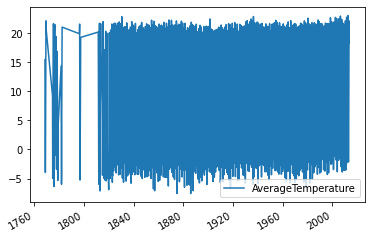

In [34]:
import matplotlib.pyplot as plt



df = all_country[0]
df['day'] = 1
df = df.set_index(pd.to_datetime(df[['year', 'month', 'day']].astype(str).agg('-'.join, axis=1),format='%Y-%B-%d'))
df.plot(y='AverageTemperature')

In [8]:
    #Grammar Scores
    gs = grammar_score(t5_narrative)
    t5_g_scores.append(gs)
    if gs != 1.0:
        t5_g_mistake.append((graph, t5_narrative))
    
    gs = grammar_score(t5_narrative_topk)
    t5_g_scores_topk.append(gs)
    if gs != 1.0:
        t5_g_mistake_topk.append((graph, t5_narrative_topk))
    
    gs = grammar_score(t5_narrative_topp)
    t5_g_scores_topp.append(gs)
    if gs != 1.0:
        t5_g_mistake_topp.append((graph, t5_narrative_topp))
    
    gs = grammar_score(bart_narrative)                          
    bart_g_scores.append(gs)
    if gs != 1.0:
        bart_g_mistake.append((graph, bart_narrative))
        
    gs = grammar_score(bart_narrative_topk)
    bart_g_scores_topk.append(gs)
    if gs != 1.0:
        bart_g_mistake_topk.append((graph, bart_narrative_topk))
    
    gs = grammar_score(bart_narrative_topp)
    bart_g_scores_topp.append(gs)
    if gs != 1.0:
        bart_g_mistake_topp.append((graph, bart_narrative_topp))
    
    print("Grammar Scores Computed: ", iso)

Processing Country:  United States

 Data Loaded

 Waves Detected


/home/mandarsharma/Segmentation/segmentation.py:28: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  (p,residuals,rank,s) = np.linalg.lstsq(A,y)



 Segmentation Done

 Trends Detected

 Graph Calculated

 Templated Computed
Simple Generation Complete:  United States
Top-k Complete:  United States
Top-p Complete:  United States
RE Scores Computed:  United States
TTE Scores Computed:  United States
Grammar Scores Computed:  United States
Processing Country:  India

 Data Loaded

 Waves Detected


/home/mandarsharma/Segmentation/segmentation.py:28: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  (p,residuals,rank,s) = np.linalg.lstsq(A,y)



 Segmentation Done

 Trends Detected

 Graph Calculated

 Templated Computed
Simple Generation Complete:  India
Top-k Complete:  India
Top-p Complete:  India
RE Scores Computed:  India
TTE Scores Computed:  India
Grammar Scores Computed:  India
Processing Country:  Brazil

 Data Loaded

 Waves Detected


/home/mandarsharma/Segmentation/segmentation.py:28: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  (p,residuals,rank,s) = np.linalg.lstsq(A,y)



 Segmentation Done

 Trends Detected

 Graph Calculated

 Templated Computed
Simple Generation Complete:  Brazil
Top-k Complete:  Brazil
Top-p Complete:  Brazil
RE Scores Computed:  Brazil
TTE Scores Computed:  Brazil
Grammar Scores Computed:  Brazil
Processing Country:  Russia

 Data Loaded

 Waves Detected


/home/mandarsharma/Segmentation/segmentation.py:28: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  (p,residuals,rank,s) = np.linalg.lstsq(A,y)



 Segmentation Done

 Trends Detected

 Graph Calculated

 Templated Computed
Simple Generation Complete:  Russia
Top-k Complete:  Russia
Top-p Complete:  Russia
RE Scores Computed:  Russia
TTE Scores Computed:  Russia
Grammar Scores Computed:  Russia
Processing Country:  United Kingdom

 Data Loaded

 Waves Detected


/home/mandarsharma/Segmentation/segmentation.py:28: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  (p,residuals,rank,s) = np.linalg.lstsq(A,y)



 Segmentation Done

 Trends Detected

 Graph Calculated

 Templated Computed
Simple Generation Complete:  United Kingdom
Top-k Complete:  United Kingdom
Top-p Complete:  United Kingdom
RE Scores Computed:  United Kingdom
TTE Scores Computed:  United Kingdom
Grammar Scores Computed:  United Kingdom
Processing Country:  France

 Data Loaded

 Waves Detected


/home/mandarsharma/Segmentation/segmentation.py:28: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  (p,residuals,rank,s) = np.linalg.lstsq(A,y)



 Segmentation Done

 Trends Detected

 Graph Calculated

 Templated Computed
Simple Generation Complete:  France
Top-k Complete:  France
Top-p Complete:  France
RE Scores Computed:  France
TTE Scores Computed:  France
Grammar Scores Computed:  France
Processing Country:  Spain

 Data Loaded

 Waves Detected


/home/mandarsharma/Segmentation/segmentation.py:28: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  (p,residuals,rank,s) = np.linalg.lstsq(A,y)



 Segmentation Done

 Trends Detected

 Graph Calculated

 Templated Computed
Simple Generation Complete:  Spain
Top-k Complete:  Spain
Top-p Complete:  Spain
RE Scores Computed:  Spain
TTE Scores Computed:  Spain
Grammar Scores Computed:  Spain
Processing Country:  Italy

 Data Loaded

 Waves Detected


/home/mandarsharma/Segmentation/segmentation.py:28: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  (p,residuals,rank,s) = np.linalg.lstsq(A,y)



 Segmentation Done

 Trends Detected

 Graph Calculated

 Templated Computed
Simple Generation Complete:  Italy
Top-k Complete:  Italy
Top-p Complete:  Italy
RE Scores Computed:  Italy
TTE Scores Computed:  Italy
Grammar Scores Computed:  Italy
Processing Country:  Turkey

 Data Loaded

 Waves Detected


/home/mandarsharma/Segmentation/segmentation.py:28: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  (p,residuals,rank,s) = np.linalg.lstsq(A,y)



 Segmentation Done

 Trends Detected

 Graph Calculated

 Templated Computed
Simple Generation Complete:  Turkey
Top-k Complete:  Turkey
Top-p Complete:  Turkey
RE Scores Computed:  Turkey
TTE Scores Computed:  Turkey
Grammar Scores Computed:  Turkey
Processing Country:  Germany

 Data Loaded

 Waves Detected


/home/mandarsharma/Segmentation/segmentation.py:28: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  (p,residuals,rank,s) = np.linalg.lstsq(A,y)



 Segmentation Done

 Trends Detected

 Graph Calculated

 Templated Computed
Simple Generation Complete:  Germany
Top-k Complete:  Germany
Top-p Complete:  Germany
RE Scores Computed:  Germany
TTE Scores Computed:  Germany
Grammar Scores Computed:  Germany


In [54]:
import pickle
data = {
    'countries': countries,
    'all_t5_narrative': all_t5_narrative,
    'all_t5_narrative_topk': all_t5_narrative_topk,
    'all_t5_narrative_topp': all_t5_narrative_topp,
    'all_country': all_country,
    'all_country_gtemp_raw': all_country_gtemp_raw
}

# Save the data to a pickle file
with open('t5-small_evaluation_results.pickle', 'wb') as f:
    pickle.dump(data, f)

In [14]:
import pickle
data = pickle.load(open('t5-small_evaluation_results.pickle','rb'))
data['all_t5_narrative_topp']

['The first measurement of the Global Temperature took place in the US in 1768. From 1768 to 1969, to 8.89 degrees Celsius, the temperature increased to 2.91 degrees Celsius. The temperature between 1969 and 1980 was -2.19. There were a temperature increased to 9.23 in 1980 to 2000 and a temperature that drew to 21.61 in 2000. In from 2000 to 2013 the temperature was 14.07 the temperature was 6.97 the temperature was sharp. The temperature during 2013 to 2013 was on the rise with a sharp increase of to 18.27 celsius. Global Temperature reached 23.01 in 2012. ',
 'Global Temperature took place in India in 1796. The temperature from 1796 to 1816 and temperature from 1816 to 1849 were decreased to 29.51. the temperature from 1849 to 1866 increased to 19.91 degrees C. The temperature of 83 degrees Celsius for the period between 1897 and 1976 was 17.04. In the years 1977 to 2013, the temperature when the temperature is 10cf is 26.55 is 16.24. Global Temperature peak was observed in 1921 at 

In [9]:
#RE Scores
print("*** RE Scores ***")
print("template_re_scores: ", np.mean(template_re_scores))
print("t5_re_scores: ", np.mean(t5_re_scores))
print("t5_re_scores_topk: ", np.mean(t5_re_scores_topk))
print("t5_re_scores_topp: ", np.mean(t5_re_scores_topp))
print("bart_re_scores: ", np.mean(bart_re_scores))
print("bart_re_scores_topk: ", np.mean(bart_re_scores_topk))
print("bart_re_scores_topp: ", np.mean(bart_re_scores_topp))

print("\n")
print("*** Diversity Scores ***")
#Diveristy Scores
print("template_tte_scores: ", np.mean(template_tte_scores))
print("t5_tte_scores: ", np.mean(t5_tte_scores))
print("t5_tte_scores_topk: ", np.mean(t5_tte_scores_topk))
print("t5_tte_scores_topp: ", np.mean(t5_tte_scores_topp))
print("bart_tte_scores: ", np.mean(bart_tte_scores))
print("bart_tte_scores_topk: ", np.mean(bart_tte_scores_topk))
print("bart_tte_scores_topp: ", np.mean(bart_tte_scores_topp))

print("\n")
print("*** Grammar Scores ***")
#Grammar Scores
print("t5_g_scores: ", np.mean(t5_g_scores))
print("t5_g_scores_topk: ", np.mean(t5_g_scores_topk))
print("t5_g_scores_topp: ", np.mean(t5_g_scores_topp))
print("bart_g_scores: ", np.mean(bart_g_scores))
print("bart_g_scores_topk: ", np.mean(bart_g_scores_topk))
print("bart_g_scores_topp: ", np.mean(bart_g_scores_topp))

*** RE Scores ***
template_re_scores:  -32.60000000000001
t5_re_scores:  67.479
t5_re_scores_topk:  66.064
t5_re_scores_topp:  66.98
bart_re_scores:  63.959
bart_re_scores_topk:  64.581
bart_re_scores_topp:  65.467


*** Diversity Scores ***
template_tte_scores:  0.37362918642999043
t5_tte_scores:  0.39800298942676315
t5_tte_scores_topk:  0.4648429017172216
t5_tte_scores_topp:  0.4459926517363096
bart_tte_scores:  0.4230103896435353
bart_tte_scores_topk:  0.40254574550059957
bart_tte_scores_topp:  0.4141072704373586


*** Grammar Scores ***
t5_g_scores:  0.9160556938702124
t5_g_scores_topk:  0.962284671126657
t5_g_scores_topp:  0.9597113481616681
bart_g_scores:  0.9200155183341259
bart_g_scores_topk:  0.9444883556410734
bart_g_scores_topp:  0.935676241115152
